# SingleObjectTracker

## 15 Minutes to SingleObjectTracker: A Beginner's Guide

## Introduction

In the world of object tracking, the `SingleObjectTracker` class serves as a versatile and efficient foundation for tracking individual objects. It provides a standardized structure, streamlining the tracking process and making it easier to create customized tracking solutions. This guide will help you understand the philosophy behind it, how to use it, and how to create your own custom tracker by extending it.

## Philosophy

The philosophy behind `SingleObjectTracker` is to provide a flexible, robust, and straightforward base for single object tracking tasks. It encapsulates common tracking functionalities, while offering hooks that allow you to adapt and extend these functionalities to suit your specific needs.

## Usage

### 1. Initialization Phase

Using `SingleObjectTracker` is intuitive. When a `SingleObjectTracker` object is created, the following happens:

- `__init__()` method is invoked:
  - `pre_initialize()` hook is called.
  - Internal state variables are reset and initialized.
  - Tracklet is updated with the initial observations (target).
  - `post_initialize()` hook is called.

```python
def __init__(self, target, window_size, step_size, *args, **kwargs):
    ...
```

The `pre_initialize()` and `post_initialize()` hooks can be overridden in subclasses to add custom behavior before and after initialization.


### 2. Tracking Phase
The `track()` method is used to process a sequence of frames.

```python
def track(self, sequence: Union[Iterable[Any], np.ndarray]) -> Tracklet:
    ...
```
The tracking flow is as follows:

- `pre_track()` hook is called.
- The input sequence is processed in windows.
  - For each window, `process_sequence_item()` is called.
    - `update()` is called to get the updated state (needs to be implemented by the subclass).
    - The updated state is checked for required types and used to update the tracklet.
- `post_track()` hook is called.

The `pre_track()` and `post_track()` hooks can be overridden in subclasses to add custom behavior before and after tracking.
### 3. Hyperparameter Tuning Phase

The `tune_hparams()` method is used to tune the tracker's hyperparameters using Optuna.

```python
def tune_hparams(self, frames, target, ground_truth_positions, n_trials=100, hparam_search_space=None, metric=iou_scores, verbose=False, return_study=False):
    ...


In [1]:
%load_ext autoreload
%autoreload 2

### Lets see how to use it in practice with MeanShiftTracker

#### MeanShiftTracker

Mean Shift Tracking is a non-parametric, feature-based algorithm used primarily in computer vision for tracking objects in video streams. This algorithm has gained popularity due to its simplicity, efficiency, and robustness in handling scale, orientation, and affine transformations.

The primary principle of the Mean Shift Tracking algorithm is to locate the maxima of a density function. It iteratively shifts a window (also known as a kernel) towards regions of higher density until convergence is reached. The convergence is generally at the peak of a density function, and this is where the object of interest is most likely to be found.

![mean_shift_tracking](./assets/mean_shift_00.gif)

The image above shows how the mean shift converges to the center of the object location. The mean shift algorithm would not converge if the object does not lie within the extended search window.

> Image source: [Mean Shift for Tracking, Akshay Chavan](https://medium.com/swlh/mean-shift-for-tracking-cbc06f7b8a5f)

First, we need to set up the `Camera` object for capturing frames.

In [2]:
import sportslabkit as slk

dataset_path = slk.datasets.get_path("wide_view")
path_to_csv = sorted(dataset_path.glob("annotations/*.csv"))[0]
path_to_mp4 = sorted(dataset_path.glob("videos/*.mp4"))[0]

root = slk.utils.get_git_root()
cam = slk.Camera(path_to_mp4)

Since the `MeanShiftTracker` requires an initial bounding box, we will use an object detector to detect the object in the first frame.

Using cache found in /Users/atom/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-4-15 torch 2.0.1 CPU

Fusing layers... 
[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


     bbox_left    bbox_top  bbox_width  bbox_height      conf  class
0  3466.698975  795.775635   57.064941   102.608887  0.566605    0.0
1  2834.732422  589.441895   26.749268    56.258850  0.407977    0.0
2  3062.123535  600.152588   30.410889    46.600647  0.351591    0.0
3  3741.482910  668.911499   31.904541    56.530884  0.277318    0.0


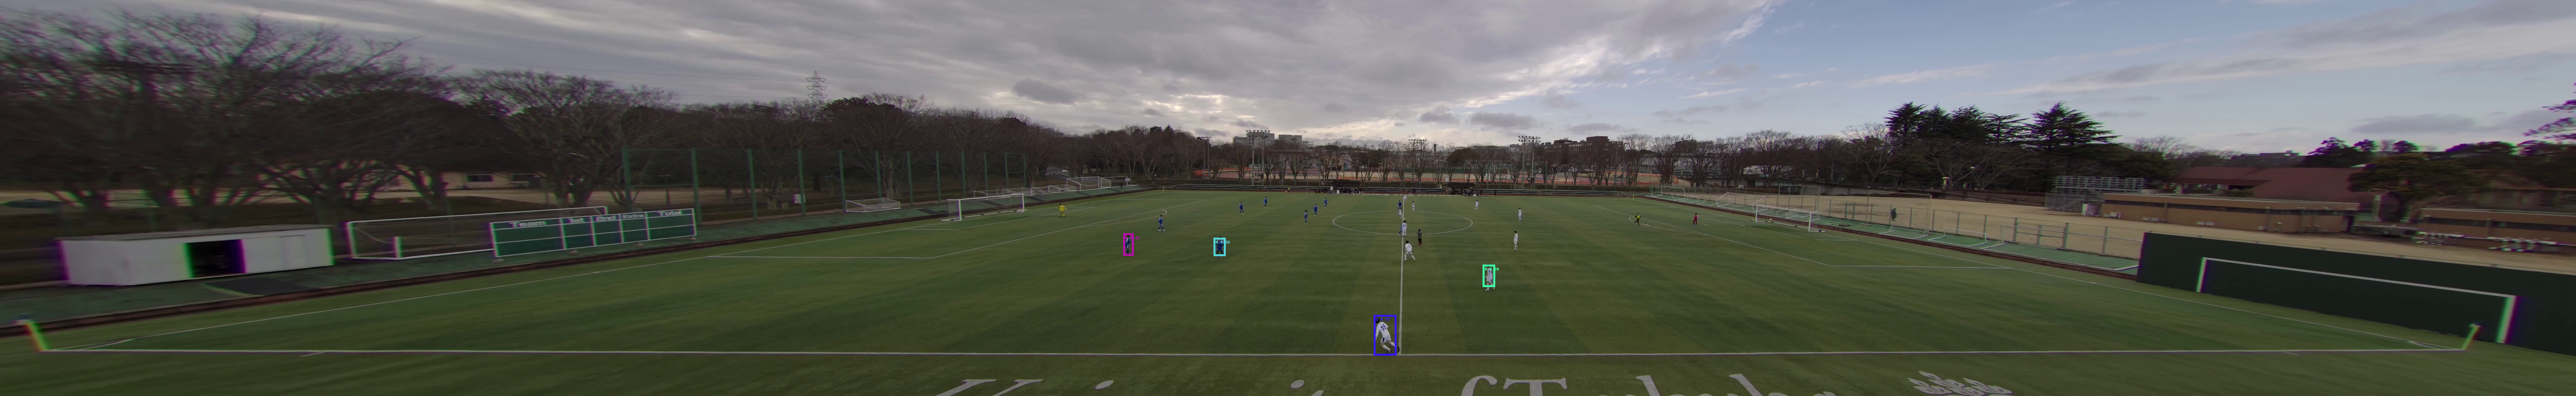

In [3]:
# let's load the first frame of the video
frame = cam.get_frame(0)

# define the path to the model checkpoint
model_name = "yolov5s"
inference_config = {"size": 960} # make this smaller to speed up inference

# define the player detection model
det_model = slk.detection_model.load(model_name, inference_config=inference_config)

det_result = det_model(frame)[0]

print(det_result.to_df()) # print the results as a dataframe
det_result.show(width=5) # show the bounding boxes on the frame

Lets use the bounding box with the highest confidence score as the initial bounding box.

In [4]:
from sportslabkit.sot import MeanShiftTracker
from IPython.display import Video

# Define the initial target object using a bounding box (x, y, width, height)
initial_target = det_result.preds[0, :4].astype(int) # Use the first ground truth position as the initial target
initial_frame = frame # Use the first frame as the initial frame
target = {"box": initial_target}

# Create and initialize the MeanShiftTracker
tracker = MeanShiftTracker(target=target, initial_frame=initial_frame)

# Track the target object in the sequence of frames
frames = cam[:30] # get the first 25 frames 

In [5]:
from PIL import Image 
import numpy as np

slk.logger.set_log_level("INFO")

# Since we also have the ground truth, we can tune the mean shift tracker's parameters
bbdf_gt = slk.load_df(path_to_csv)

# Select the target
bbdf_target = bbdf_gt.get_data(playerid='8', teamid='0')
tracker.reset()
tracker.tune_hparams(
    frames=frames[1:],
    ground_truth_positions=bbdf_target.loc[1:30],
    verbose=False,
    n_trials=100
)

Hyperparameter search space: 
self:
	bins: {'type': 'categorical', 'values': [8, 16, 32, 64, 128]}
	max_iterations: {'type': 'categorical', 'values': [5, 10, 15, 20]}
	termination_eps: {'type': 'categorical', 'values': [1, 2, 3, 4, 5]}


({'bins': 8, 'max_iterations': 5, 'termination_eps': 2}, 0.035978909809706736)

In [6]:
tracklet = tracker.track(frames)

bbdf = tracklet.to_bbdf()
save_path = "assets/meanshift_tracking_results.mp4"
bbdf.visualize_frames(cam.video_path, save_path)
Video(save_path)

Writing video: 60it [00:03, 19.39it/s]


Well that didn't work! The mean shift algorithm is not robust to fast motion. We need to use a more robust tracker for this task.

## Creating a Custom Tracker

Here we will walkthrough creating a minimum cost flow tracker using the `SingleObjectTracker` class as a base.

### Minimum Cost Flow Tracker

Minimum cost flow is a mathematical optimization problem related to network flow. The problem involves a directed graph with a capacity and a cost assigned to each edge. The goal is to send a certain amount of flow from a source node to a sink node such that the total cost (flow multiplied by cost) is minimized, while respecting the capacity constraints of the edges.

The minimum cost flow problem can be formulated for data association in single object tracking. Here, the nodes represent object detections in different frames, and the edges represent the potential associations between detections in consecutive frames. The capacity can represent the maximum number of objects that can be associated between two frames, and the cost can represent the dissimilarity between the associated detections (for example, based on the Euclidean distance between their positions).

In this context, solving the minimum cost flow problem gives the best set of associations between detections in different frames, such that the total dissimilarity is minimized and no more than a certain number of associations are made between each pair of consecutive frames.

This approach has several advantages, including the ability to handle missed detections and false alarms, and to track objects through occlusions. However, it also has some challenges, such as dealing with changes in the object's appearance, and setting the appropriate cost and capacity for each edge.

In [7]:
from sportslabkit.logger import set_log_level
from sportslabkit.matching import SimpleBatchMatchingFunction
from sportslabkit.sot import MinimumCostFlowTracker

set_log_level("INFO")
matching_fn = SimpleBatchMatchingFunction()

# define the player detection model
model_config = {"size": 960, "conf":0.1} # make this smaller to speed up inference
det_model = slk.detection_model.load(model_name, inference_config=inference_config)

image_model = slk.image_model.load("resnet50", {"image_size": 224})

motion_model = None

tracker = MinimumCostFlowTracker(
    target=target,
    initial_frame=initial_frame,
    detection_model=det_model,
    window_size=30,
    image_model=image_model,
    motion_model=motion_model,
    matching_fn=matching_fn,
)

tracklet = tracker.track(frames[:30])

bbdf = tracklet.to_bbdf()
save_path = "tracking_results-xxx.mp4"
bbdf.visualize_frames(cam.video_path, save_path)
Video(save_path)

Using cache found in /Users/atom/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-4-15 torch 2.0.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Writing video: 31it [00:00, 38.76it/s]


## Advanced Usage

To fully harness the power of `SingleObjectTracker`, it's important to understand how to use its hooks and how to integrate your own models for detection, image processing, and motion modeling.

### Using Hooks

Hooks are special methods that you can override in your custom tracker to customize its behavior at certain points during tracking. For instance, you could override the `update_tracklet_observations` method to add custom logic for updating the tracklet with new observations:

```python
class CustomTracker(SingleObjectTracker):
    # ...
    def update_tracklet_observations(self, states: Dict[str, Any]):
        # Custom logic for updating observations
        super().update_tracklet_observations(states)
```

### Integrating Your Own Models

`SingleObjectTracker` allows you to integrate your own models for object detection, image processing, and motion modeling. To do this, you simply pass your models to the `SingleObjectTracker` constructor when creating a new tracker:

```python
tracker = SingleObjectTracker(
    detection_model=my_detection_model,
    image_model=my_image_model,
    motion_model=my_motion_model
)
```

Then, you can use these models in your custom tracker's methods:

```python
class CustomTracker(SingleObjectTracker):
    # ...
    def update(self, current_frame):
        detections = self.detection_model(current_frame)
        # ...
```

In this way, `SingleObjectTracker` provides a flexible framework for integrating your own models and algorithms into the tracking process.

## Best Practices

Here are a few best practices to keep in mind when using `SingleObjectTracker` and creating your own custom trackers:

- **Ensure compatibility:** Make sure your models and methods are compatible with the `SingleObjectTracker` interface. For instance, your detection model should output detections in a format that `SingleObjectTracker` can work with.

- **Use hooks wisely:** Hooks provide a powerful way to customize `SingleObjectTracker`, but be careful not to overcomplicate your tracker by adding too much custom logic. Try to keep your tracker as simple and straightforward as possible.

- **Leverage existing functionality:** `SingleObjectTracker` already provides a lot of functionality out of the box. Before adding your own logic, see if you can achieve your goal using the existing methods and models.

By following these best practices, you can get the most out of `SingleObjectTracker` and create efficient, robust trackers for your specific tasks.

We hope this guide has provided a clear introduction to `SingleObjectTracker` and its usage. Remember, the real power of `SingleObjectTracker` lies in its flexibility and extensibility. Don't hesitate to experiment and create your own custom trackers that perfectly suit your needs. Happy tracking!